In [32]:
# %load_ext autoreload
# %autoreload 2

In [33]:
import gc
import os
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torchaudio as ta
from data_utils import SpeechDataset, filter_yt_df, yt_data_to_df
from eval_utils import (_normalize_text, calculate_metrics,
                        calculate_single_wer, infer_batches, print_metrics,
                        wav2vec_inferece, whisper_inferece)
from IPython.display import Audio
from tqdm import tqdm

In [34]:
target_sr = 16000

In [35]:
video_dir = r'F:/BIG_FILES/AI_DATA/2024_STT'
if not os.path.exists(video_dir):
    print('Video directory not found')
    raise FileNotFoundError(video_dir)
    
cache_dir = './cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [36]:
# yt_df, video_df, segment_df = yt_data_to_df(video_dir, do_load_transcripts=True)
yt_df = pd.read_parquet('yt_df.parquet')
video_df = pd.read_parquet('video_df.parquet')
segment_df = pd.read_parquet('segment_df.parquet')
display(yt_df.head(3), video_df.head(3), segment_df.head(3))
print(f'Number of videos: {len(video_df)}')
print(f'Number of segments: {len(segment_df)}')

,video_id,video_path,video_url,language,is_generated,num_segments,segment_durations,segment_id,segment_path,transcript_path,segment_duration,transcript,valid_audio
0,-13pQeao9BQ,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ,https://www.youtube.com/watch?v=-13pQeao9BQ,de,True,15,"[19.890000000000015, 20.49000000000001, 19.199...",0,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,19.890,das stelle ich hier ausdrücklich fest nur gut ...,True
1,-13pQeao9BQ,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ,https://www.youtube.com/watch?v=-13pQeao9BQ,de,True,15,"[19.890000000000015, 20.49000000000001, 19.199...",1,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,20.490,sie befördern jeder rest seiner fraktion ist d...,True
2,-13pQeao9BQ,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ,https://www.youtube.com/watch?v=-13pQeao9BQ,de,True,15,"[19.890000000000015, 20.49000000000001, 19.199...",2,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,19.199,das ist erstens keine straftat und zweitens in...,True


,video_id,video_path,video_url,language,is_generated,num_segments,segment_durations
0,-13pQeao9BQ,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ,https://www.youtube.com/watch?v=-13pQeao9BQ,de,True,15,"[19.890000000000015, 20.49000000000001, 19.199..."
1,-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4,https://www.youtube.com/watch?v=-3sWj2tYFe4,de,False,15,"[19.519999999999982, 20.64, 19.359999999999985..."
2,-3zgJme7tkM,F:/BIG_FILES/AI_DATA/2024_STT\-3zgJme7tkM,https://www.youtube.com/watch?v=-3zgJme7tkM,tr,True,15,"[19.30000000000001, 20.279999999999973, 22.380..."


,video_id,segment_id,segment_path,transcript_path,segment_duration,transcript,valid_audio
0,-13pQeao9BQ,0,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,19.890,das stelle ich hier ausdrücklich fest nur gut ...,True
1,-13pQeao9BQ,1,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,20.490,sie befördern jeder rest seiner fraktion ist d...,True
2,-13pQeao9BQ,2,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-13pQeao9BQ\tran...,19.199,das ist erstens keine straftat und zweitens in...,True


Number of videos: 1821
Number of segments: 28522


In [37]:
yt_df.to_parquet('yt_df.parquet')
video_df.to_parquet('video_df.parquet')
segment_df.to_parquet('segment_df.parquet')

In [38]:
print(f"Original number of segments: {len(yt_df)}")
print(f'Number of german segments: {len(yt_df[yt_df.language == "de"])}')
print(f'Number of english segments: {len(yt_df[yt_df.language == "en"])}')
print(f"Number of auto generated segments: {len(yt_df[yt_df.is_generated == True])}")
print(f"Number of manual segments: {len(yt_df[yt_df.is_generated == False])}")
print(f"Total duration: {yt_df.segment_duration.sum() / 3600:.2f}h")
print(f"Total duration (manual): {yt_df[yt_df.is_generated == False].segment_duration.sum() / 3600:.2f}h")
print(f"Valid audio segments: {yt_df[yt_df.valid_audio].count().segment_id} / {len(yt_df)}")
min_segment_length = None
max_segment_length = 30
target_language = "de"
use_auto_generated = False
min_words = None
max_words = None
drop_columns = ["language", "is_generated", "num_segments", "segment_durations", "segment_id", "valid_audio"]
yt_df_filtered = filter_yt_df(
    yt_df,
    min_segment_length=min_segment_length,
    max_segment_length=max_segment_length,
    language=target_language,
    use_auto_generated=use_auto_generated,
    min_words=min_words,
    max_words=max_words,
)
yt_df_filtered = yt_df_filtered[yt_df_filtered.valid_audio].reset_index(drop=True)
print(f"Filtered number of segments: {len(yt_df_filtered)}")
print(f"Total duration: {yt_df_filtered.segment_duration.sum() / 3600:.2f}h")
yt_df_filtered = yt_df_filtered.drop(columns=drop_columns)


yt_df_filtered.head(3)

Original number of segments: 28522
Number of german segments: 27612
Number of english segments: 178
Number of auto generated segments: 15815
Number of manual segments: 12707
Total duration: 164.70h
Total duration (manual): 75.17h
Valid audio segments: 28521 / 28522
Filtered number of segments: 11839
Total duration: 68.59h


,video_id,video_path,video_url,segment_path,transcript_path,segment_duration,transcript,num_words
0,-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4,https://www.youtube.com/watch?v=-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\tran...,19.52,"der sich alles selbst erarbeitet hat, lässt ei...",56
1,-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4,https://www.youtube.com/watch?v=-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\tran...,20.64,"Elon Musk. Tesla, SpaceX, Twitter. Einer der d...",39
2,-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4,https://www.youtube.com/watch?v=-3sWj2tYFe4,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\segm...,F:/BIG_FILES/AI_DATA/2024_STT\-3sWj2tYFe4\tran...,19.36,und sich mit verschiedenen Jobs über Wasser hä...,52


In [39]:
yt_df_filtered = yt_df_filtered.sample(frac=.05, random_state=42).reset_index(drop=True)
print(f"Sampled number of segments: {len(yt_df_filtered)}")
print(f"Total duration: {yt_df_filtered.segment_duration.sum() / 3600:.2f}h")
yt_df_filtered.head(3)

Sampled number of segments: 592
Total duration: 3.43h


,video_id,video_path,video_url,segment_path,transcript_path,segment_duration,transcript,num_words
0,u1upVtXcrdo,F:/BIG_FILES/AI_DATA/2024_STT\u1upVtXcrdo,https://www.youtube.com/watch?v=u1upVtXcrdo,F:/BIG_FILES/AI_DATA/2024_STT\u1upVtXcrdo\segm...,F:/BIG_FILES/AI_DATA/2024_STT\u1upVtXcrdo\tran...,24.070,"So sieht jetzt mein Make-up aus, ich bin jetzt...",41
1,5EkeDBfYimI,F:/BIG_FILES/AI_DATA/2024_STT\5EkeDBfYimI,https://www.youtube.com/watch?v=5EkeDBfYimI,F:/BIG_FILES/AI_DATA/2024_STT\5EkeDBfYimI\segm...,F:/BIG_FILES/AI_DATA/2024_STT\5EkeDBfYimI\tran...,19.101,"Ziel. Wie genau wir dahin kommen, ist mir egal...",54
2,FRuyzfNw-i8,F:/BIG_FILES/AI_DATA/2024_STT\FRuyzfNw-i8,https://www.youtube.com/watch?v=FRuyzfNw-i8,F:/BIG_FILES/AI_DATA/2024_STT\FRuyzfNw-i8\segm...,F:/BIG_FILES/AI_DATA/2024_STT\FRuyzfNw-i8\tran...,20.360,Das sind manchmal ganz verrückte Momente. Also...,79


In [40]:
yt_df_filtered.to_parquet('results/yt_df_filtered.parquet')

## EDA

array([[<Axes: title={'center': 'segment_duration'}>]], dtype=object)

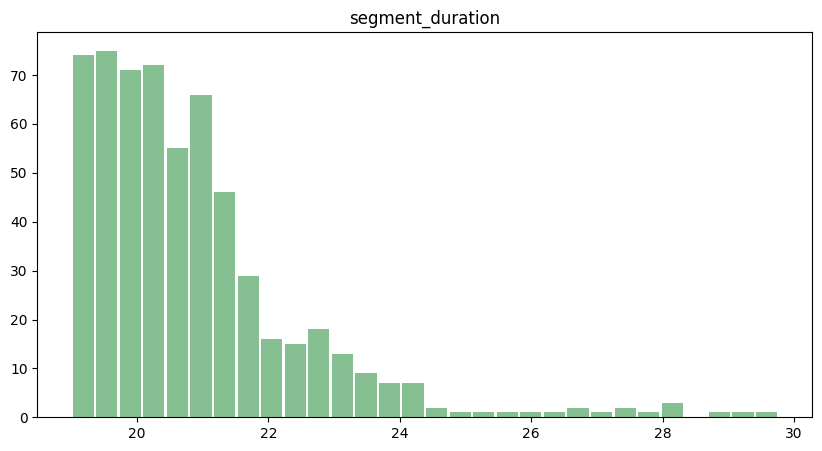

In [41]:
# histogram of segment lengths
yt_df_filtered.hist(column='segment_duration', bins=30, figsize=(10, 5), grid=False, color='#86bf91', zorder=2, rwidth=0.9)

array([[<Axes: title={'center': 'num_words'}>]], dtype=object)

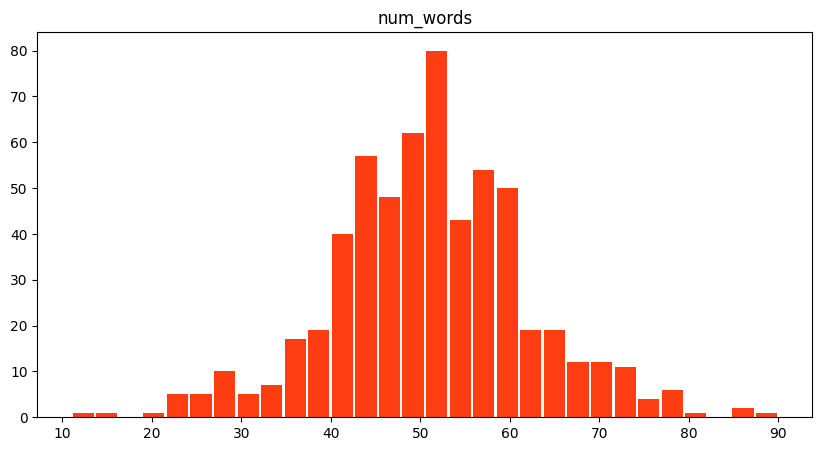

In [42]:
# histogram of number of words
yt_df_filtered.hist(column='num_words', bins=30, figsize=(10, 5), grid=False, color='#fe3e12', zorder=2, rwidth=0.9)

In [43]:
# load a random audio file
sample_segment = yt_df_filtered.sample(1).iloc[0]
audio_file_path = sample_segment['segment_path']
transcript = sample_segment['transcript']
wave, sr = ta.load(audio_file_path)
print(f'Loaded audio file: {audio_file_path}')
print(f'Wave shape: {wave.shape}')
print(f'Sample rate: {sr}')
display(Audio(wave.numpy(), rate=sr))

res_wave = ta.transforms.Resample(sr, target_sr)(wave)
print(f'Wave shape after resampling: {res_wave.shape}')
display(Audio(res_wave.numpy(), rate=target_sr))

# show the transcript but only x words per line
words = transcript.split()
words_per_line = 15
for i in range(0, len(words), words_per_line):
    print(' '.join(words[i:i+words_per_line]))

Loaded audio file: F:/BIG_FILES/AI_DATA/2024_STT\xk0Cbdvq-oc\segments\segment_09.mp3
Wave shape: torch.Size([1, 884205])
Sample rate: 44100


Wave shape after resampling: torch.Size([1, 320800])


Es wird immer dann aktiv, wenn wir tagträumen oder in Gedanken versinken. Aber auch, wenn
wir über uns selbst, die Vergangenheit oder die Zukunft nachdenken. Durch Meditation lernt man, dieses
Netzwerk quasi herunterzufahren. Andere Hirnareale, die uns beim Konzentrieren helfen, werden währenddessen aktiver. Wenn du
deinen Körper beobachtest,


# Model evaluation

In [44]:
def custom_collate_fn(x):
    return x

def empty_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [45]:
batch_size = 16

## Whisper-Tiny

In [46]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

whisper_type = "tiny"

MODEL_ID = f"openai/whisper-{whisper_type}"
torch_dtype = torch.float16

whisper_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dataset = SpeechDataset(yt_df_filtered, whisper_processor, processor_args, target_sr)
whisper_loader = torch.utils.data.DataLoader(whisper_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_loader, whisper_inferece, whisper_model, whisper_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper {whisper_type} avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [01:28<00:00,  2.39s/it]


Whisper tiny avg. Inference Time: Mean - 1.30s Sum - 48.27s
WER: 0.3459
WIL: 0.4887
WIP: 0.5113
CER: 0.1909
ED: 67.3564


In [47]:
whisper_results_df.to_parquet(f'results/whisper_{whisper_type}_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/whisper_{whisper_type}_metrics_df.parquet')
del whisper_model, whisper_processor, whisper_dataset, whisper_loader
empty_cache()

## Whisper-Base

In [48]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

whisper_type = "base"

MODEL_ID = f"openai/whisper-{whisper_type}"
torch_dtype = torch.float16

whisper_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dataset = SpeechDataset(yt_df_filtered, whisper_processor, processor_args, target_sr)
whisper_loader = torch.utils.data.DataLoader(whisper_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_loader, whisper_inferece, whisper_model, whisper_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper {whisper_type} avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [01:10<00:00,  1.91s/it]


Whisper base avg. Inference Time: Mean - 1.53s Sum - 56.66s
WER: 0.2733
WIL: 0.3808
WIP: 0.6192
CER: 0.1612
ED: 58.4797


In [49]:
whisper_results_df.to_parquet(f'results/whisper_{whisper_type}_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/whisper_{whisper_type}_metrics_df.parquet')
del whisper_model, whisper_processor, whisper_dataset, whisper_loader
empty_cache()

## Whisper-Small

In [50]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

whisper_type = "small"

MODEL_ID = f"openai/whisper-{whisper_type}"
torch_dtype = torch.float16

whisper_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dataset = SpeechDataset(yt_df_filtered, whisper_processor, processor_args, target_sr)
whisper_loader = torch.utils.data.DataLoader(whisper_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_loader, whisper_inferece, whisper_model, whisper_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper {whisper_type} avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [01:30<00:00,  2.45s/it]


Whisper small avg. Inference Time: Mean - 2.07s Sum - 76.68s
WER: 0.1926
WIL: 0.2706
WIP: 0.7294
CER: 0.1317
ED: 50.4645


In [51]:
whisper_results_df.to_parquet(f'results/whisper_{whisper_type}_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/whisper_{whisper_type}_metrics_df.parquet')
del whisper_model, whisper_processor, whisper_dataset, whisper_loader
empty_cache()

## Whisper-Medium

In [52]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

whisper_type = "medium"

MODEL_ID = f"openai/whisper-{whisper_type}"
torch_dtype = torch.float16

whisper_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dataset = SpeechDataset(yt_df_filtered, whisper_processor, processor_args, target_sr)
whisper_loader = torch.utils.data.DataLoader(whisper_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_loader, whisper_inferece, whisper_model, whisper_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper {whisper_type} avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [02:29<00:00,  4.05s/it]


Whisper medium avg. Inference Time: Mean - 3.68s Sum - 135.98s
WER: 0.1713
WIL: 0.2310
WIP: 0.7690
CER: 0.1255
ED: 48.2517


In [53]:
whisper_results_df.to_parquet(f'results/whisper_{whisper_type}_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/whisper_{whisper_type}_metrics_df.parquet')
del whisper_model, whisper_processor, whisper_dataset, whisper_loader
empty_cache()

## Whisper-Large-V3

In [54]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

whisper_type = "large-v3"

MODEL_ID = f"openai/whisper-{whisper_type}"
torch_dtype = torch.float16

whisper_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dataset = SpeechDataset(yt_df_filtered, whisper_processor, processor_args, target_sr)
whisper_loader = torch.utils.data.DataLoader(whisper_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_loader, whisper_inferece, whisper_model, whisper_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper {whisper_type} avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [03:05<00:00,  5.02s/it]


Whisper large-v3 avg. Inference Time: Mean - 4.63s Sum - 171.13s
WER: 0.1358
WIL: 0.1870
WIP: 0.8130
CER: 0.1018
ED: 40.8733


In [55]:
whisper_results_df.to_parquet(f'results/whisper_{whisper_type}_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/whisper_{whisper_type}_metrics_df.parquet')
del whisper_model, whisper_processor, whisper_dataset, whisper_loader
empty_cache()

## Whisper-Large-Dist

In [56]:
from transformers import (AutoProcessor, WhisperConfig,
                          WhisperForConditionalGeneration)

MODEL_ID = "primeline/distil-whisper-large-v3-german"
torch_dtype = torch.bfloat16

whisper_dist_model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=cache_dir, torch_dtype=torch_dtype)
whisper_dist_processor = AutoProcessor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
whisper_dist_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    "sampling_rate": target_sr,
}

whisper_dist_dataset = SpeechDataset(yt_df_filtered, whisper_dist_processor, processor_args, target_sr)
whisper_dist_loader = torch.utils.data.DataLoader(whisper_dist_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

whisper_results_df, whisper_times = infer_batches(whisper_dist_loader, whisper_inferece, whisper_dist_model, whisper_dist_processor, torch_dtype)
whisper_metrics = calculate_metrics(whisper_results_df["normalized_decoded_output"].to_list(), whisper_results_df["normalized_gt"].to_list())
whisper_metrics_df = pd.DataFrame(whisper_metrics, index=[0])
print(f"Whisper distil large v3 german avg. Inference Time: Mean - {whisper_times["mean"]:.2f}s Sum - {whisper_times["sum"]:.2f}s")
print_metrics(whisper_metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 37/37 [01:25<00:00,  2.31s/it]


Whisper distil large v3 german avg. Inference Time: Mean - 1.91s Sum - 70.71s
WER: 0.3908
WIL: 0.5053
WIP: 0.4947
CER: 0.3010
ED: 132.4375


In [57]:
whisper_results_df.to_parquet(f'results/primeline_distil_whisper_large_v3_german_results_df.parquet')
whisper_metrics_df.to_parquet(f'results/primeline_distil_whisper_large_v3_german_metrics_df.parquet')
del whisper_dist_model, whisper_dist_processor, whisper_dist_dataset, whisper_dist_loader
empty_cache()

## Wav2Vec2ForCTC

In [58]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-german"

wav2vec_processor = Wav2Vec2Processor.from_pretrained(MODEL_ID, cache_dir=cache_dir)
wav2vec_model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID, cache_dir=cache_dir)
wav2vec_model.eval().to('cuda')

processor_args = {
    "return_tensors": "pt",
    # "padding":True,
    "sampling_rate": target_sr,
}

wav2vec_dataset = SpeechDataset(yt_df_filtered, wav2vec_processor, processor_args, target_sr)
wav2vec_loader = torch.utils.data.DataLoader(wav2vec_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

wav2vec_results_df, wav2vec_times = infer_batches(wav2vec_loader, wav2vec_inferece, wav2vec_model, wav2vec_processor)
wav2vec_metrics = calculate_metrics(wav2vec_results_df["normalized_decoded_output"].to_list(), wav2vec_results_df["normalized_gt"].to_list())
wav2vec_metrics_df = pd.DataFrame(wav2vec_metrics, index=[0])
print(f"wav2vec avg. Inference Time: Mean - {wav2vec_times["mean"]:.2f}s Sum - {wav2vec_times["sum"]:.2f}s")
print_metrics(wav2vec_metrics)

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-german were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-german and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You

wav2vec avg. Inference Time: Mean - 0.53s Sum - 39.30s
WER: 0.3764
WIL: 0.5651
WIP: 0.4349
CER: 0.1495
ED: 53.4578


In [59]:
wav2vec_results_df.to_parquet(f'results/wav2vec_results_df.parquet')
wav2vec_metrics_df.to_parquet(f'results/wav2vec_metrics_df.parquet')
del wav2vec_model, wav2vec_processor, wav2vec_dataset, wav2vec_loader
empty_cache()

## WhisperX

In [60]:
import whisperx

device = "cuda" 
batch_size = 16 # reduce if low on GPU mem
compute_type = "int8" # change to "int8" if low on GPU mem (may reduce accuracy)

whisperx_model = whisperx.load_model("large-v3", device, compute_type=compute_type, language="de", download_root=cache_dir)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint W:\Others\Cache\Cache__Torch\whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


In [61]:
results_whisperx = []
audio_paths = yt_df_filtered.segment_path.to_list()
gts = yt_df_filtered.transcript.to_list()
normalized_gts = [_normalize_text(x) for x in gts]
print(f"Number of audio files: {len(audio_paths)}")

times_whisperx = []

for audio_path, gt, ngt in tqdm(zip(audio_paths, gts, normalized_gts), total=len(audio_paths)):
    start = time.time()
    result = whisperx_model.transcribe(audio_path)
    times_whisperx.append(time.time() - start)
    pred = " ".join([x["text"] for x in result["segments"]]).strip()
    norm_pred = _normalize_text(pred)
    is_valid = True if len(ngt) > 0 else False
    results_whisperx.append({
        "decoded_output": pred,
        "normalized_decoded_output": norm_pred,
        "gt": gt,
        "normalized_gt": ngt,
        "audio_path": audio_path,
        "valid": is_valid,
        "wer": calculate_single_wer(norm_pred, ngt) if is_valid else -1,
    })

results_whisperx_df = pd.DataFrame(results_whisperx)
whisperx_metrics = calculate_metrics(results_whisperx_df["normalized_decoded_output"].to_list(), results_whisperx_df["normalized_gt"].to_list())
whisperx_metrics_df = pd.DataFrame(whisperx_metrics, index=[0])
print(f"WhisperX avg. Inference Time: Mean - {np.mean(times_whisperx):.2f}s Sum - {np.sum(times_whisperx):.2f}s")
print_metrics(whisperx_metrics)

Number of audio files: 592


100%|██████████| 592/592 [15:45<00:00,  1.60s/it]


WhisperX avg. Inference Time: Mean - 1.60s Sum - 944.34s
WER: 0.1234
WIL: 0.1723
WIP: 0.8277
CER: 0.0896
ED: 35.2399


In [62]:
results_whisperx_df.to_parquet(f'results/whisperx_results_df.parquet')
whisperx_metrics_df.to_parquet(f'results/whisperx_metrics_df.parquet')
del whisperx_model
empty_cache()